# 1. Build A LDA Model of 2012 London Olympics

## 1.1 Packages Importing

In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet  import WordNetLemmatizer
from nltk import FreqDist
import pandas as pd
import numpy as py
import string
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, Phrases, TfidfModel
from gensim.corpora import Dictionary
from gensim.models.phrases import Phraser
# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pattern.en import lemma

C:\ProgramData\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## 1.2 Parameters Setting 

In [97]:
col = 2                             # Define which columns are used for topic modelling.
coherence_type = 'c_v'
min_len = 4                       # Define the short word length
no_below =  2                   #a threshold filtering out number of occurrence of the tokens among documents  no larger than 5
no_above = 0.9                 #the portion of a word in total corpus size
chunksize = 2000              #Number of documents to be used in each training chunk
eval_every = None             # Don't evaluate model perplexity, takes too much time.
num_topics =  21              #The number of requested latent topics to be extracted from the training corpus.
num_passes = 20              #Number of passes through the corpus during training
iterations = 100                #Maximum number of iterations through the corpus when inferring the topic distribution of a corpus.
alpha = 50.0/num_topics   #expresses our a-priori belief for each topics’ probability
#eta = 'auto'     
eta =      0.01     #A-priori belief on word probability
random_state  = 12345     #Either a randomState object or a seed to generate one. Useful for reproducibility.

## 1.3 Corpus Reading 

In [3]:
df = pd.read_csv("NewChunkAll-STRIP-ASCII.csv", header = None)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8
0,1,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,Examination of Witnesses,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,SEPTEMBER,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,MS BARBARA CASSANI,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,Q Chairman Good morning Ms Cassani I should ve...,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,Ms Cassani Thank you very much Thank you very ...,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,a good time for the country to get behind an ...,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,p repeating not just to you but to myself and ...,Oly-Raw-New-Chunks/NewChunk1/Examination_of_Wi...,the venues and how we will be approaching the ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23147 entries, 0 to 23146
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       23147 non-null  int64 
 1   1       23147 non-null  object
 2   2       23147 non-null  object
 3   3       383 non-null    object
 4   4       193 non-null    object
 5   5       7 non-null      object
 6   6       7 non-null      object
 7   7       1 non-null      object
 8   8       1 non-null      object
dtypes: int64(1), object(8)
memory usage: 1.6+ MB


## 1.4 Data Processing

Word number: 23147


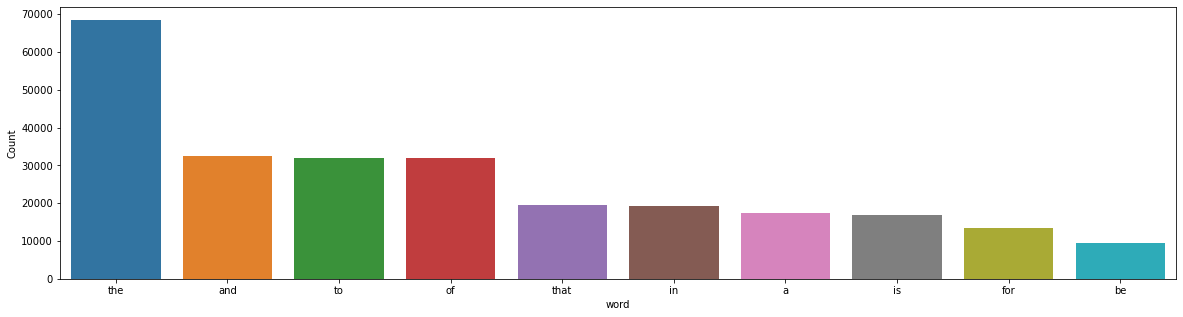

In [9]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join(['%s' %text for text in x])
    all_words = all_words.split()
    
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

print('Word number: %d'% (len(df[col])))
freq_words(df[2],10) 

<ipython-input-10-03fde7e31d6c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = df[col][i].lower()
<ipython-input-10-03fde7e31d6c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][i] = tokenizer.tokenize(df[col][i])


Tokens number: 19326


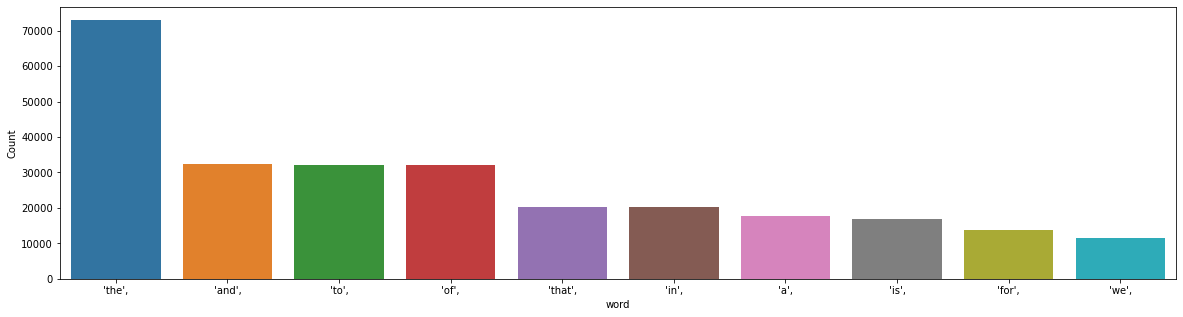

In [10]:
#Tokenize the corpus 
tokenizer = RegexpTokenizer(r'\w+')
for i in range (len(df)):
    df[col][i] = df[col][i].lower()
    df[col][i] = tokenizer.tokenize(df[col][i])

print('Tokens number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing number: 19133


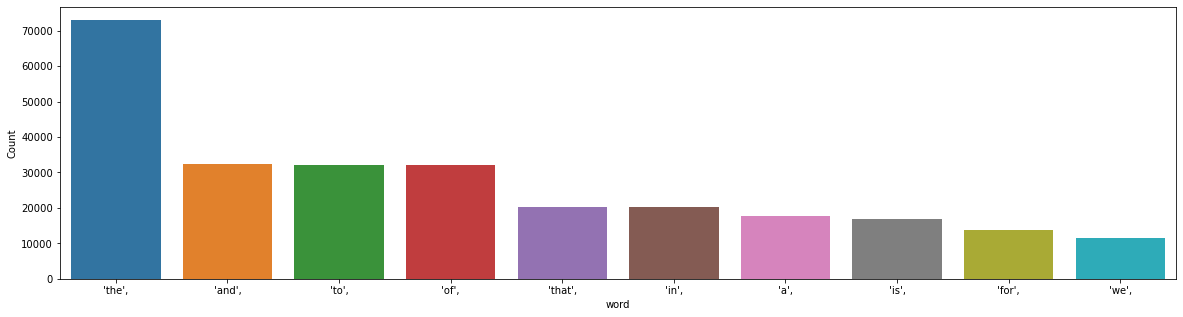

In [11]:
#Remove the number
df[col] = [ [token for token in doc if not token.isnumeric()] for doc in df[col]]

print('Tokens number after removing number: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing stop words: 18997


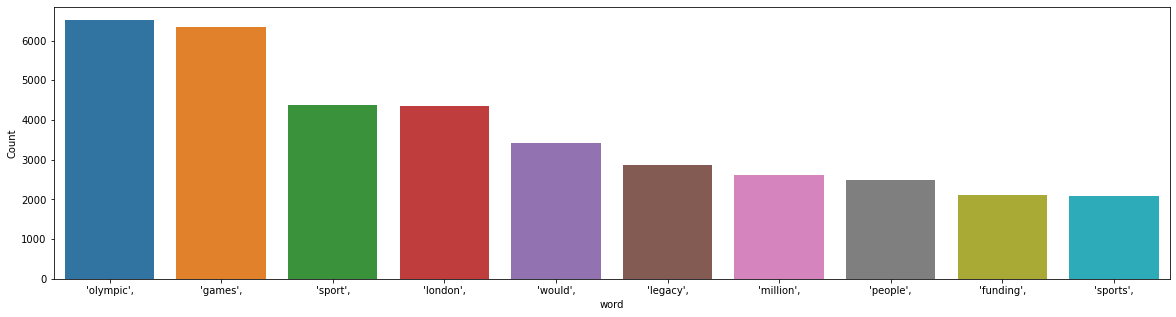

In [12]:
#Reomve stop words
stop_words = stopwords.words('english')
df[col] = [ [token for token in doc if not token in stop_words] for doc in df[col] ]
print('Tokens number after removing stop words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after removing short words: 18261


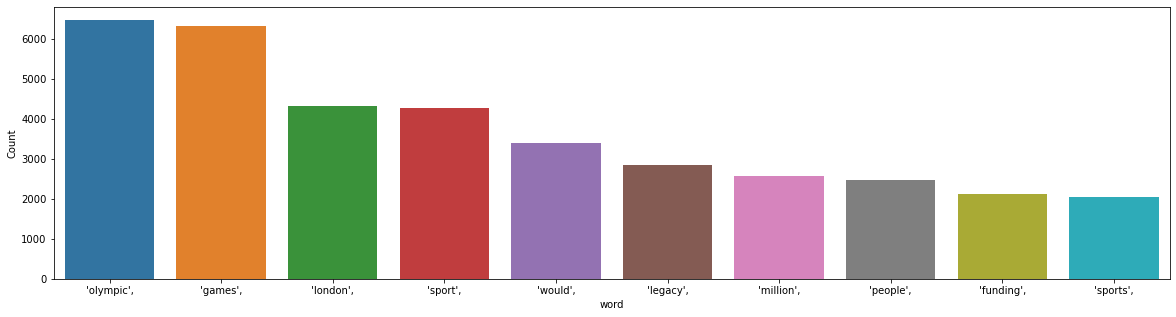

In [13]:
#Remove short words (length< min_len)
df[col] = [ [token for token in doc if not len(token) < min_len] for doc in df[col] ]
print('Tokens number after removing short words: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after lemmation: 13865


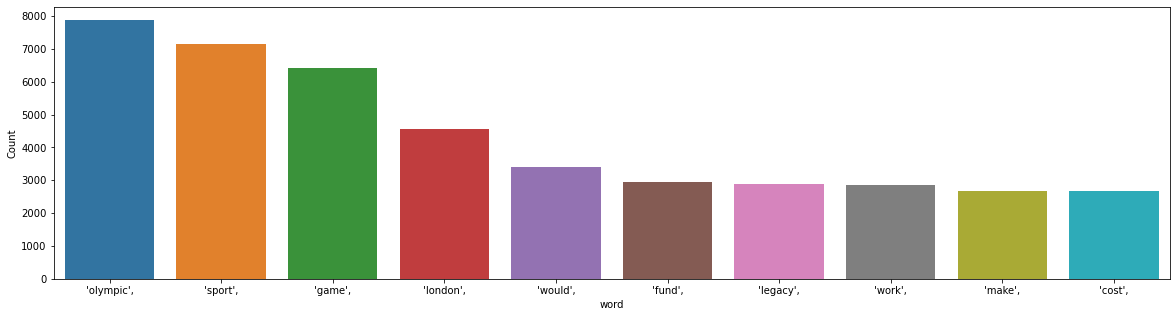

In [15]:
# Corpus Lemmation
df[col] = [ [lemma(token) for token in doc ] for doc in df[col] ]

print('Tokens number after lemmation: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

Tokens number after adding bigram: 14790


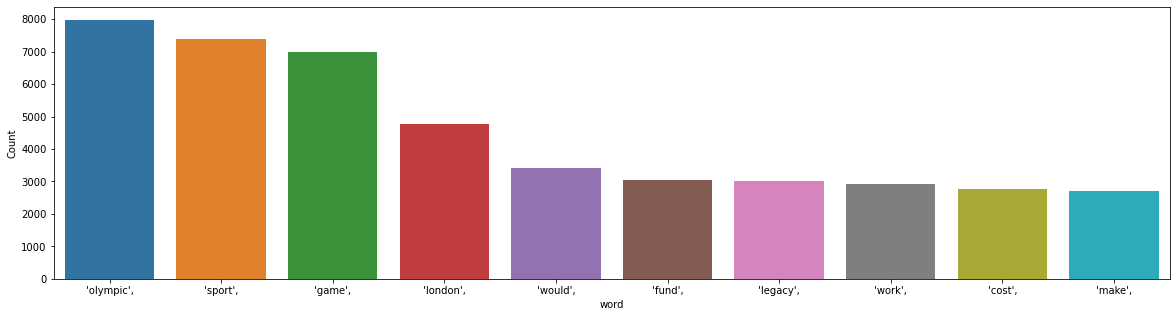

In [16]:
# Make bigram
bigrams_phases = Phrases(df[col], min_count = 10)
for i in range(len(df[col])):
    for token in bigrams_phases[df[col][i]]:
        if '_' in token:
            df[col][i].append(token)            

print('Tokens number after adding bigram: %d'% (len(Dictionary(df[col]))))
freq_words(df[col],10) 

## 1.5 The LDA Model Building

In [17]:
# Build a dictionary
LOdict = Dictionary(df[col])

print('Tokens number after creating dictionary: %d'% (len(LOdict)))

Tokens number after creating dictionary: 14790


In [18]:
#Remove  words occur less than no_below documents and more then no_above/documents
LOdict.filter_extremes(no_below = no_below, no_above = no_above)

print('Tokens number after tf-idf: %d'% (len(LOdict)))

Tokens number after tf-idf: 8878


In [19]:
# Create bag of word for corpus
LOcorpus = [LOdict.doc2bow(doc) for doc in df[col]]

In [23]:
#Mapping from word IDs to words. It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = LOdict 

In [98]:
# Buila a LDA model for LONDON OLYPLMICS
LOldamodel = LdaModel(
    corpus = LOcorpus,
    id2word = id2word,
    chunksize = chunksize,
    alpha = alpha,
    eta = eta,
    iterations = iterations,
    num_topics = num_topics,
    passes = num_passes,
    eval_every = eval_every,
    random_state = random_state
)

In [99]:
#Compute Coherence Score
coherence_model_lda = CoherenceModel(model = LOldamodel, texts = df[col], dictionary = LOdict, coherence=coherence_type)
coherence_lda = coherence_model_lda.get_coherence()
print('Cohernece Score c_v: ', coherence_lda, ' when topics number: ', num_topics)

Cohernece Score c_v:  0.5837262060727991  when topics number:  21


([<matplotlib.axis.XTick at 0x1f427962040>,
 <a list of 11 Text major ticklabel objects>)

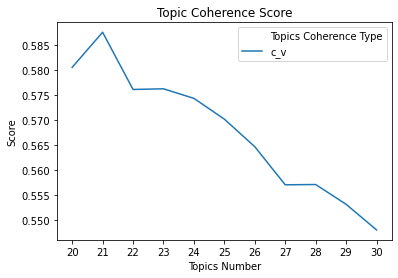

In [101]:
tc_score = pd.DataFrame(pd.read_excel("topic coherence.xlsx"))
tc = sns.lineplot(x = 'Topics Number', y = 'Score', hue = 'Topics Coherence Type', data = tc_score)
tc.set(title = 'Topic Coherence Score')
plt.xticks([20,21,22,23,24,25,26,27,28,29,30])
#tc.set_xticks(range(len(tc_score))) # <--- set the ticks first
#tc.set_xticklabels(['20','21','22','23','24','25','26','27','28','29','30'])

## 1.6 Corpus Classification

In [102]:
#Make a classifier to classify each paragraph of London Olympics Corpus
classifer = list()
for d in df[col]:
    bow = LOdict.doc2bow(d)
    belong = LOldamodel.get_document_topics(bow,per_word_topics=False)
    classifer.append(belong)
    
classiferdf = pd.DataFrame(classifer)

In [103]:
#Transform London Olympics Corpus to Dataframe
LOdf = pd.DataFrame(df[col])

In [104]:
#Make the Dataframe of the biggest distribution topics of each paragraph
MTopics =  list()
for i in LOldamodel.get_document_topics(LOcorpus)[:]:
    listj=[]
    for j in i:
        listj.append(j[1])
    bz=listj.index(max(listj))
    #print(i[bz][0],i,listj,listj.index(max(listj)))
    #print(i[bz][0])
    MTopics.append(bz)

MTopics = pd.DataFrame(MTopics)

In [105]:
#Integrate dataframe of orgrinal corpus, classifier, and the biggest distribution of each paragraph
classifer_document = pd.concat([LOdf,MTopics,classiferdf],axis=1)
classifer_document

,2,0,0,1,2,3,4,5,6,7,...,11,12,13,14,15,16,17,18,19,20
0,"[examination, witness, examination_witness]",12,"(0, 0.04492481)","(1, 0.06378013)","(2, 0.04492481)","(3, 0.04492481)","(4, 0.04492481)","(5, 0.04492481)","(6, 0.06378406)","(7, 0.04492481)",...,"(11, 0.04492481)","(12, 0.06378921)","(13, 0.04492481)","(14, 0.04492481)","(15, 0.04492481)","(16, 0.04492481)","(17, 0.04492481)","(18, 0.04492481)","(19, 0.04492481)","(20, 0.04492481)"
1,[september],5,"(0, 0.046685673)","(1, 0.046685673)","(2, 0.046685673)","(3, 0.046685673)","(4, 0.046685673)","(5, 0.06548236)","(6, 0.046685673)","(7, 0.046685673)",...,"(11, 0.047459807)","(12, 0.046685673)","(13, 0.046685673)","(14, 0.046715748)","(15, 0.046685673)","(16, 0.046685673)","(17, 0.046685673)","(18, 0.046685673)","(19, 0.046685673)","(20, 0.046685673)"
2,"[barbara, cassani]",0,"(0, 0.04761905)","(1, 0.04761905)","(2, 0.04761905)","(3, 0.04761905)","(4, 0.04761905)","(5, 0.04761905)","(6, 0.04761905)","(7, 0.04761905)",...,"(11, 0.04761905)","(12, 0.04761905)","(13, 0.04761905)","(14, 0.04761905)","(15, 0.04761905)","(16, 0.04761905)","(17, 0.04761905)","(18, 0.04761905)","(19, 0.04761905)","(20, 0.04761905)"
3,"[chairman, good, morn, cassani, much, like, we...",16,"(0, 0.03238903)","(1, 0.031020133)","(2, 0.022936907)","(3, 0.023417944)","(4, 0.023382459)","(5, 0.032904502)","(6, 0.057810817)","(7, 0.027960822)",...,"(11, 0.07710239)","(12, 0.05663849)","(13, 0.050006915)","(14, 0.04891702)","(15, 0.10689488)","(16, 0.17223786)","(17, 0.022897981)","(18, 0.051504105)","(19, 0.022940025)","(20, 0.038655773)"
4,"[cassani, thank, much, thank, much, give, oppo...",16,"(0, 0.06370852)","(1, 0.060615547)","(2, 0.016551003)","(3, 0.015417181)","(4, 0.017537579)","(5, 0.050699145)","(6, 0.058661588)","(7, 0.03816663)",...,"(11, 0.073852025)","(12, 0.020393182)","(13, 0.08607185)","(14, 0.03914902)","(15, 0.08498637)","(16, 0.20279633)","(17, 0.012872771)","(18, 0.05850714)","(19, 0.025023092)","(20, 0.036802795)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23142,"[advertise, strong, likelihood, visit, within,...",13,"(0, 0.045908038)","(1, 0.04790235)","(2, 0.037246004)","(3, 0.05056964)","(4, 0.04034016)","(5, 0.06357046)","(6, 0.03506263)","(7, 0.034051366)",...,"(11, 0.052463617)","(12, 0.0340941)","(13, 0.11619017)","(14, 0.048648342)","(15, 0.048364796)","(16, 0.03401766)","(17, 0.054107796)","(18, 0.03401766)","(19, 0.07367799)","(20, 0.03401766)"
23143,"[jonathan, stephen, permanent, secretary, jona...",19,"(0, 0.04409239)","(1, 0.04409239)","(2, 0.04409239)","(3, 0.04409239)","(4, 0.04409239)","(5, 0.04409239)","(6, 0.04409239)","(7, 0.04409239)",...,"(11, 0.04409239)","(12, 0.04409239)","(13, 0.04409239)","(14, 0.06260724)","(15, 0.04409239)","(16, 0.04409239)","(17, 0.04409239)","(18, 0.04409239)","(19, 0.081120595)","(20, 0.06246353)"
23144,[december],12,"(0, 0.046685405)","(1, 0.046685405)","(2, 0.046685405)","(3, 0.046685405)","(4, 0.046685405)","(5, 0.046685405)","(6, 0.046685405)","(7, 0.046685405)",...,"(11, 0.046685405)","(12, 0.066291906)","(13, 0.046685405)","(14, 0.046685405)","(15, 0.046685405)","(16, 0.046685405)","(17, 0.046685405)","(18, 0.046685405)","(19, 0.046685405)","(20, 0.046685405)"
23145,[pefc],0,"(0, 0.04761905)","(1, 0.04761905)","(2, 0.04761905)","(3, 0.04761905)","(4, 0.04761905)","(5, 0.04761905)","(6, 0.04761905)","(7, 0.04761905)",...,"(11, 0.04761905)","(12, 0.04761905)","(13, 0.04761905)","(14, 0.04761905)","(15, 0.04761905)","(16, 0.04761905)","(17, 0.04761905)","(18, 0.04761905)","(19, 0.04761905)","(20, 0.04761905)"


In [106]:
#Output final dataframe
classifer_document.columns = ["Corpus","Biggest distribution topic","T0%","T1%","T2%","T3%","T4%","T5%","T6%","T7%","T8%","T9%","T10%",
                             "T11%","T12%","T13%","T14%","T15%","T16%","T17%","T18%","T19%","T20%",
                             ]

classifer_document.to_csv(path_or_buf = 'C:/Users/jason/Documents/Exeter University/business project/code/output/classifer.csv')

In [107]:
#Output topics distribution of whole corpus
topic_distribution = pd.DataFrame(LOldamodel.print_topics(num_topics = num_topics))
topic_distribution.columns = ["Topic index","Topic Distribution"]
topic_distribution
topic_distribution.to_csv(path_or_buf = 'C:/Users/jason/Documents/Exeter University/business project/code/output/topic distribution.csv',index=False)

## 2. The LDA Model Visulization

### 2.1 Packages Importing

In [118]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

### 2.2 Visulization

In [120]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(LOldamodel, LOcorpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16    -0.223968 -0.026799       1        1  6.191311
15    -0.237326 -0.043782       2        1  5.180450
19     0.056295  0.211538       3        1  5.001903
13    -0.150913 -0.104177       4        1  4.977276
11    -0.161688 -0.096396       5        1  4.895555
0      0.014061 -0.202926       6        1  4.879670
18     0.065908  0.037203       7        1  4.850573
9      0.024778  0.107472       8        1  4.825682
2      0.047119  0.175738       9        1  4.726657
5     -0.031136  0.077867      10        1  4.695083
17     0.070029  0.149270      11        1  4.688896
3     -0.042056 -0.157649      12        1  4.650473
6     -0.051497 -0.071205      13        1  4.645568
20     0.258041 -0.165057      14        1  4.645464
7     -0.129354 -0.036770      15        1  4.637972
1      0.166425 -0.119921      16        1  4.603931
14     0.260161 -0.136700      17        1  4.591206
4      0.023072  0.084714      18        1  4.512295
8      0.074991  0.045725      19        1  4.429148
10     0.017439  0.194537      20        1  4.204757
12    -0.050382  0.077317      21        1  4.166131, topic_info=         Term         Freq        Total Category  logprob  loglift
211     sport  7941.000000  7941.000000  Default  30.0000  30.0000
35    olympic  8268.000000  8268.000000  Default  29.0000  29.0000
29     london  5176.000000  5176.000000  Default  28.0000  28.0000
474    legacy  3993.000000  3993.000000  Default  27.0000  27.0000
189      game  7715.000000  7715.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
3510  october   204.520631   209.171513  Topic21  -4.6713   3.1557
287     every   418.779551   462.305001  Topic21  -3.9546   3.0793
1104    range   442.292955   504.390547  Topic21  -3.9000   3.0468
86       give   523.721249  1348.914317  Topic21  -3.7310   2.2321
505    office   276.886994   705.963103  Topic21  -4.3684   2.2422

[1021 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
719       6  0.019807         ability
719      12  0.835864         ability
719      13  0.067344         ability
719      15  0.075267         ability
55        1  0.200730            able
...     ...       ...             ...
2768     20  0.995979  write_evidence
838       5  1.000035            year
934       8  0.999761           young
1601      8  0.998006    young_people
3070      8  0.998134           youth

[1690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 16, 20, 14, 12, 1, 19, 10, 3, 6, 18, 4, 7, 21, 8, 2, 15, 5, 9, 11, 13])